In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [78]:
rt_movies_df = pd.read_csv("../data/rotten_tomatoes_movies.csv")
rt_series_df = pd.read_csv("../data/rotten_tomatoes_movies_with_money_2.csv")
rt_series_df = rt_series_df[rt_series_df.wd_film_qid.notna() & (rt_series_df.series_qid.notna() | rt_series_df.franchise_qid.notna())]


# rt_series_df['n_films_in_series'] = rt_series_df.groupby(['series_qid']).transform('size')
# rt_series_df['n_films_in_franchise'] = rt_series_df.groupby(['franchise_qid']).transform('size')
# rt_series_df = rt_series_df.query("n_films_in_series > 1 or n_films_in_franchise > 1")

print(rt_series_df.shape)
metadata_df = pd.read_csv("../data/clean_tmdb.csv")
rt_series_df = rt_series_df.merge(rt_movies_df, on="rotten_tomatoes_link", how="inner")

print(rt_series_df.shape)
rt_series_df = rt_series_df.merge(metadata_df[['budget','revenue','imdb_id']], left_on="imdb_id", right_on="imdb_id", how="left")
rt_series_df = rt_series_df.rename(columns={"budget":"imdb_budget", "revenue":"imdb_box_office_value"})
print(rt_series_df.shape)

rt_series_df = rt_series_df.merge(metadata_df[['budget','revenue','id']], left_on="tmdb_id", right_on="id", how="left")
rt_series_df = rt_series_df.rename(columns={"budget":"tmdb_budget", "revenue":"tmdb_box_office_value"})
print(rt_series_df.shape)

print("missing budget:", rt_series_df.budget_value.isna().sum())
print("filled by imdb:", (rt_series_df.budget_value.isna() & rt_series_df.imdb_budget.notna()).sum())
print("filled by tmdb:", (rt_series_df.budget_value.isna() & rt_series_df.imdb_budget.isna() & rt_series_df.imdb_budget.notna()).sum())
print("still missing:", (rt_series_df.budget_value.isna() & rt_series_df.imdb_budget.isna() & rt_series_df.tmdb_budget.isna()).sum())
print()
print("missing box_office_value:", rt_series_df.box_office_value.isna().sum())
print("filled by imdb:", (rt_series_df.box_office_value.isna() & rt_series_df.imdb_box_office_value.notna()).sum())
print("filled by tmdb:", (rt_series_df.box_office_value.isna() & rt_series_df.imdb_box_office_value.isna() & rt_series_df.tmdb_box_office_value.notna()).sum())
print("still missing:", (rt_series_df.box_office_value.isna() & rt_series_df.imdb_box_office_value.isna() & rt_series_df.tmdb_box_office_value.isna()).sum())
print()
box_office_missing = (rt_series_df.box_office_value.isna() & rt_series_df.imdb_box_office_value.isna() & rt_series_df.tmdb_box_office_value.isna())
budget_missing = (rt_series_df.budget_value.isna() & rt_series_df.imdb_budget.isna() & rt_series_df.tmdb_budget.isna())
print("one is missing: ", ((box_office_missing) | (budget_missing)).sum())

print("was missing:", (rt_series_df.box_office_value.isna() | rt_series_df.budget_value.isna()).sum())

rt_series_df['budget_value'] = rt_series_df['budget_value'].fillna(rt_series_df['imdb_budget'])
rt_series_df['budget_value'] = rt_series_df['budget_value'].fillna(rt_series_df['tmdb_budget'])

rt_series_df['box_office_value'] = rt_series_df['box_office_value'].fillna(rt_series_df['imdb_box_office_value'])
rt_series_df['box_office_value'] = rt_series_df['box_office_value'].fillna(rt_series_df['tmdb_box_office_value'])

rt_series_df = rt_series_df[rt_series_df.budget_value.notna() & rt_series_df.box_office_value.notna()]

rt_series_df = rt_series_df.rename(columns={'rotten_tomatoes_link' : 'rt_id', 'wd_film_qid': 'wd_id', 'wd_film_label' : 'title', 'bom_film_id' : 'bom_id'})
rt_series_df = rt_series_df.rename(columns={'budget_value' : 'budget', 'box_office_value': 'revenue', 'wd_film_label' : 'title', 'bom_film_id' : 'bom_id'})
rt_series_df = rt_series_df.query("budget > 0 & revenue > 0")

rt_series_df = rt_series_df.sort_values(by='original_release_date')
rt_series_df['index_in_series'] = rt_series_df.groupby(['series_qid']).cumcount()
rt_series_df['index_in_franchise'] = rt_series_df.groupby(['franchise_qid']).cumcount()

rt_series_df['n_films_in_series'] = rt_series_df.groupby(['series_qid']).transform('size')
rt_series_df['n_films_in_franchise'] = rt_series_df.groupby(['franchise_qid']).transform('size')
rt_series_df = rt_series_df.query("n_films_in_series > 1 or n_films_in_franchise > 1")

def categorize_movie_success(df: pd.DataFrame) -> pd.DataFrame:
    """
    Categorize movies based on box_office and budget values.
    Assumes marketing costs ~50% of budget.
    """
    ratio = df["revenue"] / df["budget"]

    df["roi_multiple"] = ratio  # keep the number for reference

    df["success_category"] = pd.cut(
        ratio,
        bins=[-float("inf"), 1.5, 2.0, 3.0, float("inf")],
        labels=["Flop", "Break-even", "Hit", "Blockbuster"]
    )
    return df

rt_series_df = categorize_movie_success(rt_series_df)


(1406, 21)
(1406, 42)
(1406, 44)
(1406, 47)
missing budget: 619
filled by imdb: 374
filled by tmdb: 0
still missing: 245

missing box_office_value: 600
filled by imdb: 334
filled by tmdb: 0
still missing: 266

one is missing:  274
was missing: 697


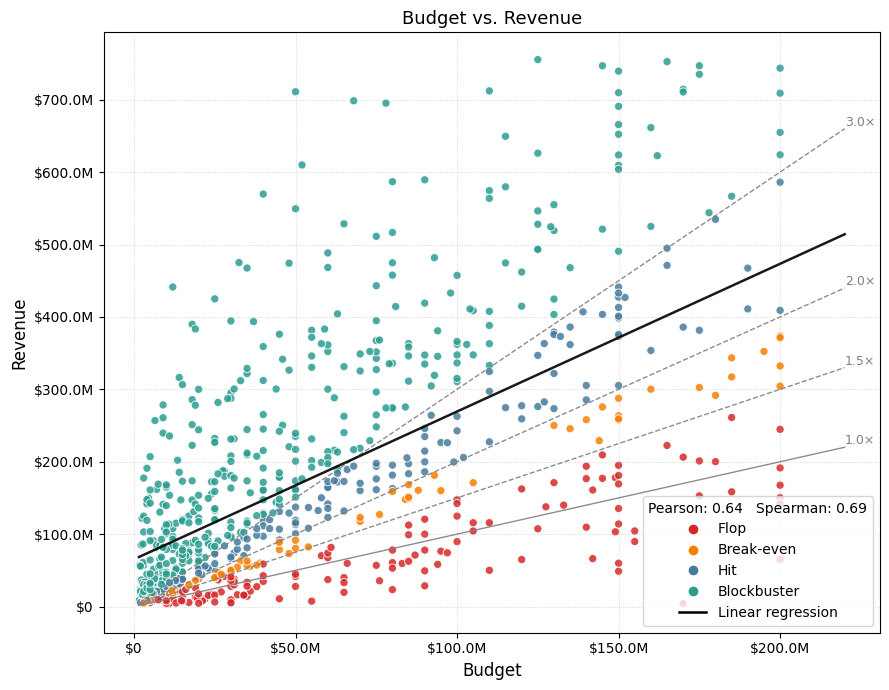

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr

# --- 1) Filter outliers by 5–95% ---
budget_q = rt_series_df['budget'].quantile([0.05, 0.95])
box_q    = rt_series_df['revenue'].quantile([0.05, 0.95])

filtered_df = rt_series_df[
    (rt_series_df['budget'].between(budget_q.iloc[0], budget_q.iloc[1])) &
    (rt_series_df['revenue'].between(box_q.iloc[0], box_q.iloc[1]))
].copy()

# --- 2) Categorize ---
# filtered_df = categorize_movie_success(filtered_df)

# --- 3) Prepare data ---
dfp = filtered_df[
    (filtered_df['budget'] > 0) &
    (filtered_df['revenue'] > 0)
].copy()
x = dfp['budget'].values
y = dfp['revenue'].values

# --- 4) Helpers ---
def human_money(v, pos=None):
    abs_v = abs(v)
    if abs_v >= 1_000_000_000:
        return f"${v/1_000_000_000:.1f}B"
    if abs_v >= 1_000_000:
        return f"${v/1_000_000:.1f}M"
    if abs_v >= 1_000:
        return f"${v/1_000:.0f}K"
    return f"${v:.0f}"

cat_colors = {
    "Flop":        "#d62828",
    "Break-even":  "#f77f00",
    "Hit":         "#457b9d",
    "Blockbuster": "#2a9d8f",
}
colors = dfp['success_category'].astype(str).map(cat_colors).fillna("#6c757d")

# --- 5) Plot ---
plt.figure(figsize=(9, 7))
plt.scatter(
    x, y,
    c=colors,
    s=35, alpha=0.85,
    edgecolor="white", linewidth=0.7
)

# Labels & formatting
plt.xlabel("Budget", fontsize=12)
plt.ylabel("Revenue", fontsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(human_money))
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_money))
plt.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)

# --- 6) Reference lines y = kx ---
kx = np.linspace(x.min()*0.9, x.max()*1.1, 200)
for k, ls in [(1.0, "-"), (1.5, "--"), (2.0, "--"), (3.0, "--")]:
    plt.plot(kx, k*kx, ls=ls, color="gray", linewidth=1.0, alpha=0.9)
    plt.text(kx[-1], k*kx[-1], f"{k:.1f}×", fontsize=9,
             va="bottom", ha="left", color="gray")

# --- 7) Regression in linear space ---
m, b = np.polyfit(x, y, 1)
y_fit = m * kx + b
plt.plot(kx, y_fit, color="black", linewidth=1.8, alpha=0.9, label="Linear regression")

# Correlations
pearson_corr, _ = pearsonr(x, y)
spearman_corr, _ = spearmanr(x, y)

# --- 8) Legend ---
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=cat,
           markerfacecolor=col, markersize=8, markeredgecolor="white")
    for cat, col in cat_colors.items()
]
legend_handles.append(Line2D([0], [0], color="black", lw=1.8, label="Linear regression"))

plt.legend(
    handles=legend_handles,
    title=f"Pearson: {pearson_corr:.2f}   Spearman: {spearman_corr:.2f}",
    loc="lower right",
    frameon=True
)

plt.title("Budget vs. Revenue", fontsize=13)
plt.tight_layout()
plt.show()


/tmp/ipykernel_3665038/1509630828.py:17: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipykernel_3665038/1509630828.py:39: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



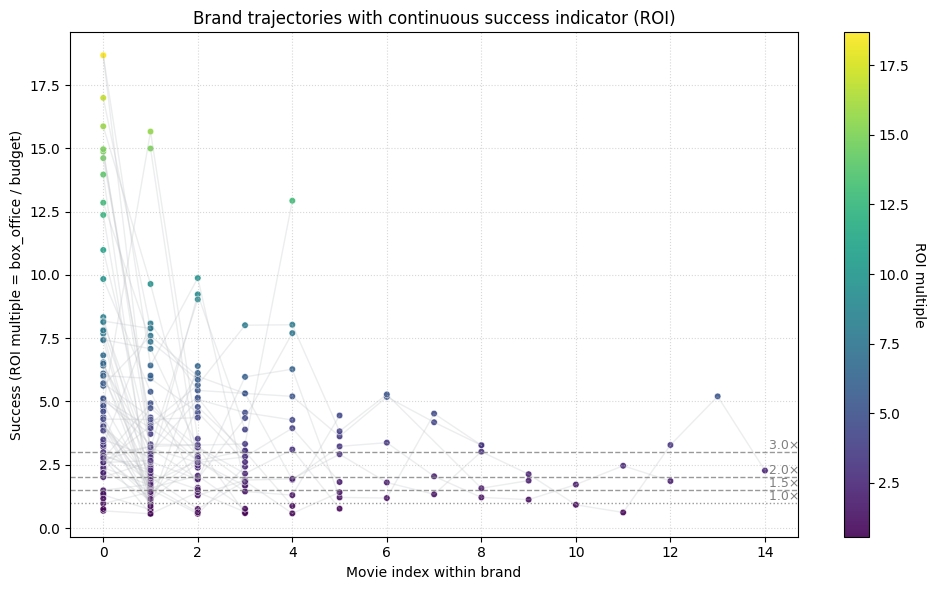

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors, cm

brand_col = 'franchise_qid'
index_in_brand_col = 'index_in_franchise'
revenue_col = 'revenue'
budget_col = 'budget'



if not {revenue_col, budget_col}.issubset(rt_series_df.columns):
    raise ValueError("Need either 'success_score' or both revenue_col & budget_col.")
df = rt_series_df.copy()
df['roi_multiple'] = df[revenue_col] / df[budget_col]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['roi_multiple'])
low, high = df['roi_multiple'].quantile([0.05, 0.95])
df = df[(df['roi_multiple'] >= low) & (df['roi_multiple'] <= high)]
score_col = 'roi_multiple'

# Clean + clip extremes so the color scale and y-range are informative
gdf = (df
       .dropna(subset=[score_col, brand_col, index_in_brand_col])
       .copy())

# Keep only positive ROI; if your score can be <=0, remove this filter
gdf = gdf[gdf[score_col] > 0]

low, high = gdf[score_col].quantile([0.01, 0.99])  # winsorize 1–99%
gdf[score_col] = gdf[score_col].clip(lower=low, upper=high)

# Prepare plotting variables
x = gdf[index_in_brand_col].values
y = gdf[score_col].values

# Color mapping by the same continuous score
norm = mcolors.Normalize(vmin=gdf[score_col].min(), vmax=gdf[score_col].max())
cmap = cm.get_cmap('viridis')

plt.figure(figsize=(10, 6))

# Light grey brand trajectories (lines), plotted in the y=continuous space
for bid, grp in gdf.sort_values([brand_col, index_in_brand_col]).groupby(brand_col):
    plt.plot(grp[index_in_brand_col], grp[score_col],
             color="#b5b8bd", alpha=0.25, linewidth=1)

# Overlay points, colored by the continuous success indicator
sc = plt.scatter(
    x, y,
    c=gdf[score_col].values,
    cmap=cmap, norm=norm,
    s=22, alpha=0.9, edgecolor='white', linewidth=0.4
)

# Optional: reference lines for ROI thresholds that you used for categories
for k, ls in [(1.0, ":"), (1.5, "--"), (2.0, "--"), (3.0, "--")]:
    plt.axhline(k, color="gray", linestyle=ls, linewidth=1.0, alpha=0.8)
    plt.text(gdf[index_in_brand_col].max(), k, f" {k:.1f}×", va="bottom", ha="left", color="gray", fontsize=9)

plt.xlabel("Movie index within brand")
plt.ylabel("Success (ROI multiple = box_office / budget)")
plt.title("Brand trajectories with continuous success indicator (ROI)")
plt.grid(True, linestyle=":", alpha=0.5)

# Colorbar for the continuous success scale
cbar = plt.colorbar(sc)
cbar.set_label("ROI multiple", rotation=270, labelpad=12)

plt.tight_layout()
plt.show()



In [24]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

brand_col = 'series_qid'
index_in_brand_col = 'index_in_series'
work_df = rt_series_df[rt_series_df[brand_col].notna()]

# Define ordered labels (low → high)
labels = ["Flop","Break-even","Hit","Blockbuster"]
label_to_idx = {lab:i for i,lab in enumerate(labels)}

# Build transitions
transitions = (
    work_df.sort_values([brand_col, index_in_brand_col])
    .assign(next_cat=lambda d: d.groupby(brand_col)['success_category'].shift(-1))
    .dropna(subset=['next_cat'])
    .loc[:, ['success_category', 'next_cat']]
    .copy()
)

# Force ordered categoricals, then get integer codes
transitions['success_category'] = pd.Categorical(
    transitions['success_category'], categories=labels, ordered=True
)
transitions['next_cat'] = pd.Categorical(
    transitions['next_cat'], categories=labels, ordered=True
)

transitions['src_idx'] = transitions['success_category'].cat.codes.astype(int)
transitions['tgt_idx'] = transitions['next_cat'].cat.codes.astype(int)

# Aggregate counts
transitions = (transitions
               .groupby(['success_category','next_cat','src_idx','tgt_idx'])
               .size()
               .reset_index(name='count'))

# Direction (now ints)
transitions['delta'] = transitions['tgt_idx'] - transitions['src_idx']

def link_color(delta):
    if delta > 0:  return "rgba(42,157,143,0.75)"   # up (green-ish)
    if delta < 0:  return "rgba(214,40,40,0.75)"    # down (red)
    return "rgba(108,117,125,0.6)"                  # same (gray)

# % of source
src_totals = transitions.groupby('success_category')['count'].transform('sum')
transitions['pct_from_src'] = 100.0 * transitions['count'] / src_totals

# Sankey fields
source = transitions['src_idx']
target = transitions['tgt_idx']
value  = transitions['count']
link_colors = transitions['delta'].map(link_color)

hovertext = (
    transitions['success_category'].astype(str) + " → " + transitions['next_cat'].astype(str) +
    "<br>Count: " + transitions['count'].astype(str) +
    "<br>% of source: " + transitions['pct_from_src'].round(1).astype(str) + "%"
)

node_x = [0.05, 0.35, 0.65, 0.95]  # enforce left→right order
node_y = [0.2, 0.4, 0.6, 0.8]
node_colors = ["#d62828", "#f77f00", "#457b9d", "#2a9d8f"]

fig = go.Figure(data=[go.Sankey(
    arrangement="fixed",
    node=dict(
        label=labels, pad=20, thickness=18,
        color=node_colors, x=node_x, y=node_y
    ),
    link=dict(
        source=source, target=target, value=value,
        color=link_colors,
        hovertemplate="%{customdata}<extra></extra>",
        customdata=hovertext
    )
)])

# Legend proxies for link direction
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
    marker=dict(size=10, color="rgba(42,157,143,0.9)"), name="Improvement"))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
    marker=dict(size=10, color="rgba(214,40,40,0.9)"),  name="Decline"))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
    marker=dict(size=10, color="rgba(108,117,125,0.8)"),name="No change"))

fig.update_layout(
    title_text="Category transitions across brands (directional, source-normalized)",
    font_size=12,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0)
)
fig.show()


/tmp/ipykernel_3665038/1756314332.py:35: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_3665038/1756314332.py:48: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [54]:
rt_series_df.franchise_label.value_counts()
# black_list = ["m/clone_wars"]

franchise_label
Godzilla              22
Star Trek             13
Q462                  10
Planet of the Apes     9
Wizarding World        9
                      ..
Peanuts                1
Zootopia               1
Moana                  1
Aladdin                1
Justice League         1
Name: count, Length: 96, dtype: int64

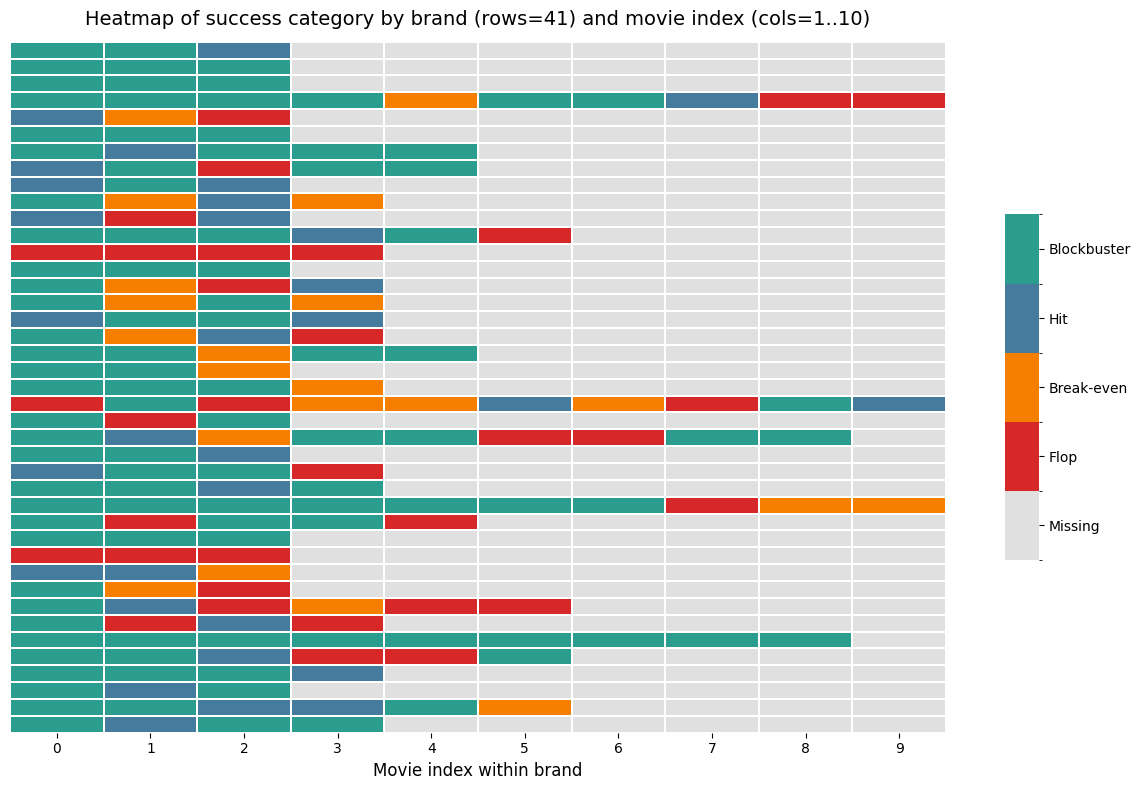

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns

brand_col = 'franchise_qid'
index_in_brand_col = 'index_in_franchise'

# Category → integer mapping
cat_to_num = {"Flop":0, "Break-even":1, "Hit":2, "Blockbuster":3}
num_to_cat = {v:k for k,v in cat_to_num.items()}

# ----- build dense grid -----
work_df = rt_series_df[rt_series_df[brand_col].notna() & (rt_series_df['n_films_in_franchise'] > 2) & (rt_series_df[index_in_brand_col] <= 10)].copy()
# map to numeric *strings-safe* to avoid categorical bleed-through
df2 = (work_df
       .assign(val=lambda d: d['success_category'].astype(str).map(cat_to_num).astype('float64'))
       .dropna(subset=['val', brand_col, index_in_brand_col]))

df2[[brand_col, index_in_brand_col, 'val']]

# collapse duplicates (brand,index): take "best" category
collapsed = (df2.groupby([brand_col, index_in_brand_col], as_index=False)['val'].max())

# all brands / full width
brands = np.sort(collapsed[brand_col].unique())
max_idx = int(collapsed[index_in_brand_col].max()) if len(collapsed) else 1
all_cols = np.arange(0, max_idx)

# pivot and reindex to full grid
mat = (collapsed
       .pivot_table(index=brand_col, columns=index_in_brand_col, values='val', aggfunc='max')
       .reindex(index=brands, columns=all_cols))

# ensure numeric, then fill missing with predefined value
MISSING_VAL = -1.0
mat = mat.astype('float64', copy=False).fillna(MISSING_VAL)

# ----- plotting -----
# colors: Missing + Flop..Blockbuster
cmap = ListedColormap(["#e0e0e0", "#d62828", "#f77f00", "#457b9d", "#2a9d8f"])
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, cmap.N)

n_rows, n_cols = mat.shape
cell_w, cell_h = 0.05, 0.1   # make cells big
fig_w = max(12, n_cols * cell_w)
fig_h = max(8,  n_rows * cell_h)

plt.figure(figsize=(fig_w, fig_h))
ax = sns.heatmap(
    mat,
    cmap=cmap, norm=norm, cbar=True,
    linewidths=0.3, linecolor="white",
    square=False,
    cbar_kws={"shrink": 0.5, "aspect": 10},  # <-- shrink legend
)

# colorbar labels
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1, 0, 1, 2, 3])
cbar.set_ticklabels(["Missing", "Flop", "Break-even", "Hit", "Blockbuster"])

# axes formatting
ax.set_xlabel("Movie index within brand", fontsize=12)
ax.set_ylabel("")              # hide brand ids (random strings)
ax.set_yticks([])              # no brand labels
# x ticks: show reasonable spacing if many columns
if n_cols > 50:
    step = max(1, n_cols // 25)
    xticks = np.arange(1, n_cols + 1, step)
    ax.set_xticks(xticks - 0.5)
    ax.set_xticklabels(xticks)
else:
    ax.set_xticks(np.arange(0.5, n_cols + 0.5))
    ax.set_xticklabels(all_cols)

plt.title(f"Heatmap of success category by brand (rows={n_rows}) and movie index (cols=1..{n_cols})",
          fontsize=14, pad=12)
plt.tight_layout()
plt.show()


/tmp/ipykernel_3665038/3900293968.py:21: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



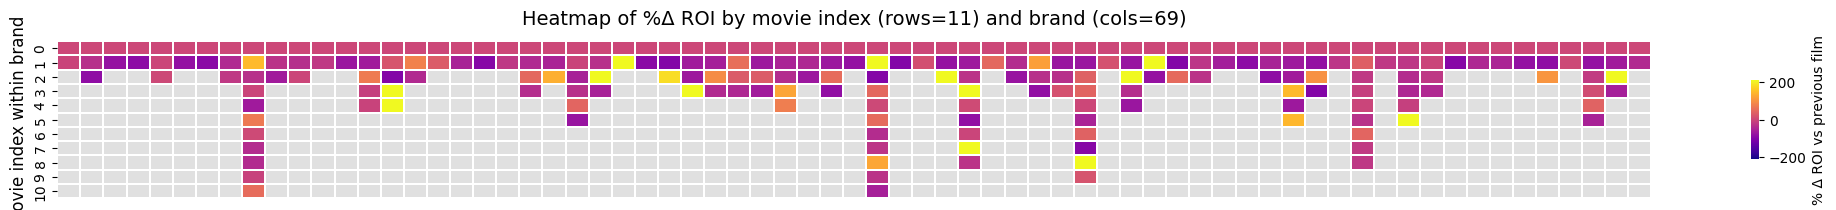

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

brand_col = 'franchise_qid'
index_in_brand_col = 'index_in_franchise'

# base ROI
rt_series_df['roi'] = rt_series_df['revenue'] / rt_series_df['budget']

# ----- build dense grid -----
work_df = rt_series_df[
    rt_series_df[brand_col].notna()
    & (rt_series_df['n_films_in_franchise'] >= 2)
    & (rt_series_df[index_in_brand_col] <= 10)
].copy()

# clean
work_df = work_df.replace([np.inf, -np.inf], np.nan)
work_df = work_df[work_df['roi'].notna()]

# keep only needed columns
df2 = work_df.loc[:, [brand_col, index_in_brand_col, 'roi']].dropna(subset=[brand_col, index_in_brand_col])

# ----- compute % delta vs previous movie within each franchise -----
# Sort within brand by index, compute pct_change*100; set first entry per brand to 0 (reference)
df2 = df2.sort_values([brand_col, index_in_brand_col]).copy()
df2['roi_pct_delta'] = (
    df2.groupby(brand_col, sort=False)['roi']
       .apply(lambda s: s.pct_change() * 100.0)
       .reset_index(level=0, drop=True)
)

# first movie in each brand = reference (0%)
first_idx_mask = df2.groupby(brand_col, sort=False)[index_in_brand_col].transform('min') == df2[index_in_brand_col]
df2.loc[first_idx_mask, 'roi_pct_delta'] = 0.0

# collapse duplicates (brand,index): mean delta if multiple rows map to same slot
collapsed = (df2.groupby([brand_col, index_in_brand_col], as_index=False)['roi_pct_delta'].mean())

# all brands / full width
brands = np.sort(collapsed[brand_col].unique())
max_idx = int(collapsed[index_in_brand_col].max()) if len(collapsed) else 1
all_cols = np.arange(0, max_idx + 1)  # include max index

# pivot and reindex to full grid; leave missing as NaN (we'll color them gray)
mat = (collapsed
       .pivot_table(index=index_in_brand_col, columns=brand_col, values='roi_pct_delta', aggfunc='mean')
       .reindex(index=all_cols, columns=brands)
       .astype('float64', copy=False))

# robust, symmetric color scaling around 0
vals = mat.to_numpy()
finite = np.isfinite(vals)
if finite.any():
    a = np.nanpercentile(np.abs(vals[finite]), 95)
    vmax = a if a > 0 else np.nanmax(np.abs(vals[finite]))
    vmax = float(vmax) if np.isfinite(vmax) and vmax > 0 else 1.0
    vmin = -vmax
else:
    vmin, vmax = -1.0, 1.0
    
# plotting
cmap = plt.cm.plasma
cmap.set_bad("#e0e0e0")  # gray for missing

n_rows, n_cols = mat.shape
cell_w, cell_h = 0.3, 0.2
fig_w = n_cols * cell_w
fig_h = n_rows * cell_h

plt.figure(figsize=(fig_w, fig_h))
ax = sns.heatmap(
    mat,
    cmap=cmap,
    norm=Normalize(vmin=vmin, vmax=vmax),
    cbar=True,
    linewidths=0.3, linecolor="white",
    square=False,
    cbar_kws={"shrink": 0.5, "aspect": 10, "label": "% Δ ROI vs previous film"},
)

# axes formatting
ax.set_ylabel("Movie index within brand", fontsize=12)
ax.set_xlabel("")  # hide brand ids
ax.set_xticks([])

plt.title(f"Heatmap of %Δ ROI by movie index (rows={n_rows}) and brand (cols={n_cols})",
          fontsize=14, pad=12)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3665038/4270134980.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



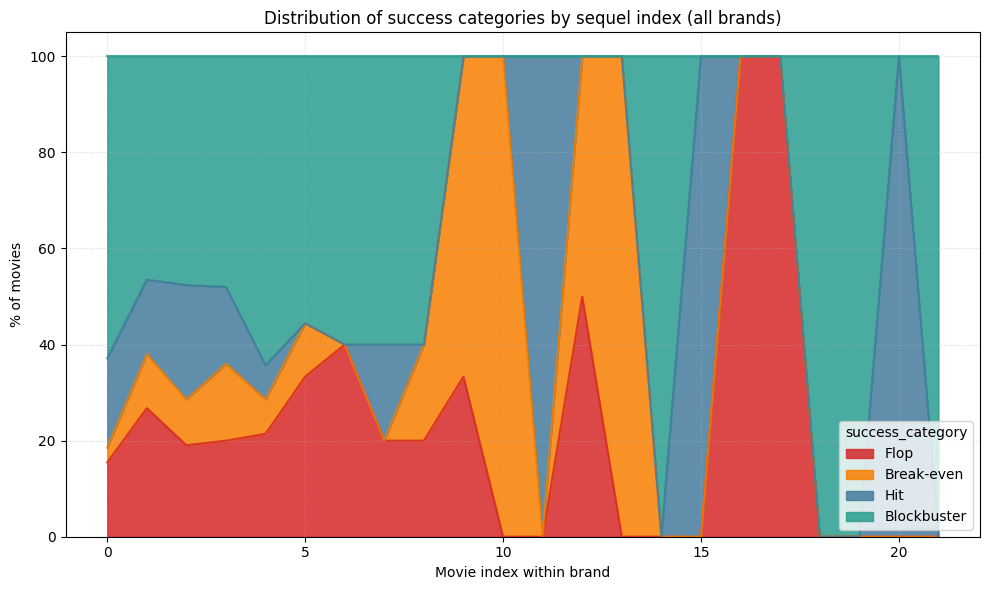

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

brand_col = 'franchise_qid'
index_in_brand_col = 'index_in_franchise'
work_df = rt_series_df[rt_series_df[brand_col].notna()].copy()

# Count per index_in_brand & category, then normalize to percentages
counts = (work_df.groupby([index_in_brand_col,'success_category'])
            .size()
            .unstack(fill_value=0)
            .sort_index())
props = counts.div(counts.sum(axis=1), axis=0) * 100.0

# Stacked area (or use .plot(kind='bar', stacked=True) for stacked bars)
ax = props.plot.area(figsize=(10,6), alpha=0.85,
                     color={"Flop":"#d62828","Break-even":"#f77f00","Hit":"#457b9d","Blockbuster":"#2a9d8f"})
ax.set_xlabel("Movie index within brand")
ax.set_ylabel("% of movies")
ax.set_title("Distribution of success categories by sequel index (all brands)")
ax.grid(True, linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()


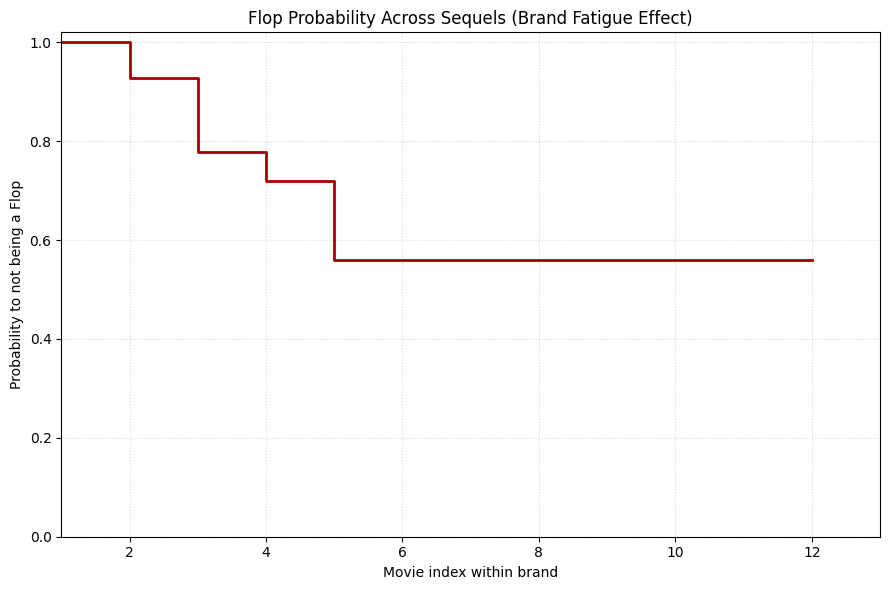

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

brand_col = 'franchise_qid'
index_in_brand_col = 'index_in_franchise'

work_df = rt_series_df[rt_series_df[brand_col].notna() & (rt_series_df['n_films_in_franchise'] > 2) & (rt_series_df[index_in_brand_col] <= 12)].copy()

# Per-brand last index and whether last is a flop
last = (work_df.sort_values([brand_col, index_in_brand_col])
          .groupby(brand_col)
          .tail(1)[[brand_col,index_in_brand_col, 'success_category']]
          .rename(columns={index_in_brand_col:'t'}))
last['event'] = (last['success_category'] == 'Flop').astype(int)  # 1=death, 0=censored

# Build KM steps: for unique times t, compute d_i (events) and n_i (at risk)
times = np.sort(last['t'].unique())
S = []
surv = 1.0
for t in times:
    # at risk: brands whose last index >= t
    at_risk = (last['t'] >= t).sum()
    # events at t: brands whose last index == t and last is flop
    d_i = ((last['t'] == t) & (last['event'] == 1)).sum()
    # KM update
    if at_risk > 0:
        surv *= (1 - d_i / at_risk)
    S.append((t, surv))

# Step plot
t_vals = [0] + [tt for tt,_ in S for _ in (0,1)]
s_vals = [1.0] + [sv for _,sv in S for _ in (1,1)]

plt.figure(figsize=(9,6))
plt.step(t_vals, s_vals, where="post", color="#A40000", linewidth=2)
plt.ylim(0, 1.02)
plt.xlim(1, max(t_vals)+1)
plt.xlabel("Movie index within brand")
plt.ylabel("Probability to not being a Flop")
plt.title("Flop Probability Across Sequels (Brand Fatigue Effect)")
plt.grid(True, linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipykernel_3665038/2950593802.py:21: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



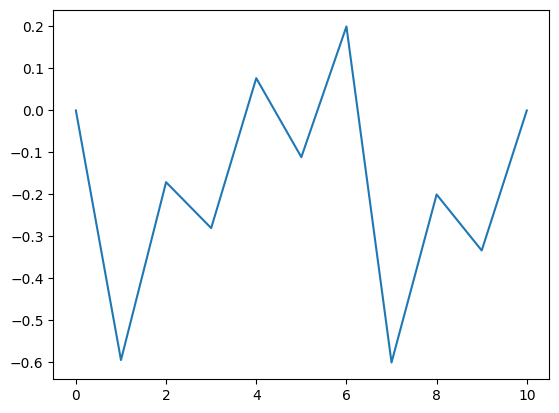

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

brand_col = 'franchise_qid'
index_in_brand_col = 'index_in_franchise'

# base ROI
rt_series_df['roi'] = rt_series_df['revenue'] / rt_series_df['budget']

# ----- build dense grid -----
work_df = rt_series_df[
    rt_series_df[brand_col].notna()
    & (rt_series_df['n_films_in_franchise'] >= 2)
    & (rt_series_df[index_in_brand_col] <= 10)
].copy()

# clean
work_df = work_df.replace([np.inf, -np.inf], np.nan)
work_df = work_df[work_df['roi'].notna()]

# keep only needed columns
df2 = work_df.loc[:, [brand_col, index_in_brand_col, 'roi']].dropna(subset=[brand_col, index_in_brand_col])

# ----- compute % delta vs previous movie within each franchise -----
# Sort within brand by index, compute pct_change*100; set first entry per brand to 0 (reference)
df2 = df2.sort_values([brand_col, index_in_brand_col]).copy()
df2['roi_pct_delta'] = (
    df2.groupby(brand_col, sort=False)['roi']
       .apply(lambda s: s.pct_change() * 100.0)
       .reset_index(level=0, drop=True)
)

# first movie in each brand = reference (0%)
first_idx_mask = df2.groupby(brand_col, sort=False)[index_in_brand_col].transform('min') == df2[index_in_brand_col]
df2.loc[first_idx_mask, 'roi_pct_delta'] = 0.0

# collapse duplicates (brand,index): mean delta if multiple rows map to same slot
collapsed = (df2.groupby([brand_col, index_in_brand_col], as_index=False)['roi_pct_delta'].mean())

# all brands / full width
brands = np.sort(collapsed[brand_col].unique())
max_idx = int(collapsed[index_in_brand_col].max()) if len(collapsed) else 1
all_cols = np.arange(0, max_idx + 1)  # include max index

# pivot and reindex to full grid; leave missing as NaN (we'll color them gray)
mat = (collapsed
       .pivot_table(index=index_in_brand_col, columns=brand_col, values='roi_pct_delta', aggfunc='mean')
       .reindex(index=all_cols, columns=brands)
       .astype('float64', copy=False))


mat[(~mat.isna()) & (mat < 0)] = -1
mat[(~mat.isna()) & (mat > 0)] = 1
mat[(~mat.isna())].mean(axis=1)
plt.plot(mat[(~mat.isna())].mean(axis=1))

In [148]:
rt_series_df.columns

Index(['rt_id', 'wd_id', 'title', 'series_qid', 'series_label',
       'franchise_qid', 'franchise_label', 'bom_id', 'imdb_id', 'tmdb_id',
       'budget', 'budget_currency_qid', 'budget_currency', 'budget_asof',
       'budget_source', 'revenue', 'box_office_currency_qid',
       'box_office_currency', 'box_office_asof', 'box_office_region_qid',
       'box_office_region', 'movie_title', 'movie_info', 'critics_consensus',
       'content_rating', 'genres', 'directors', 'authors', 'actors',
       'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'imdb_budget', 'imdb_box_office_value', 'tmdb_budget',
       'tmdb_box_office_value', 'id', 'index_in_series', 'index_in_franchise',
       'n_films_in_

In [ ]:
import numpy as np
import pandas as pd


brand_col = 'franchise_qid'
index_in_brand_col = 'index_in_franchise'
rating_col = 'roi_pct_delta'

# base ROI
# rt_series_df['roi'] = rt_series_df['revenue'] / rt_series_df['budget']

# ----- build dense grid -----
work_df = rt_series_df[
    rt_series_df[brand_col].notna()
    & (rt_series_df['n_films_in_franchise'] >= 2)
    & (rt_series_df[index_in_brand_col] <= 10)
].copy()

# clean
work_df = work_df.replace([np.inf, -np.inf], np.nan)
# work_df = work_df[work_df['roi'].notna()]

# keep only needed columns
df2 = work_df.dropna(subset=[brand_col, index_in_brand_col])

# ----- compute % delta vs previous movie within each franchise -----
# Sort within brand by index, compute pct_change*100; set first entry per brand to 0 (reference)
df2 = df2.sort_values([brand_col, index_in_brand_col]).copy()
df2[rating_col] = (
    df2.groupby(brand_col, sort=False)['audience_rating']
       .apply(lambda s: s.pct_change() * 100.0)
       .reset_index(level=0, drop=True)
)


# ---- config ----
tol = -0.05        # define "as successful" as roi_pct_delta >= tol
m = 20           # prior sample size for shrinkage (tune 10–50)
alpha = 0.05     # 95% interval

# df columns expected:
# 'Series_id', 'roi_pct_delta', 'index_of_movie_within_series'

# Keep only rows that have a previous movie (index >= 2) and non-null delta
work = (df2
        .loc[df2['n_films_in_franchise'] >= 2, 
             [brand_col,rating_col,'n_films_in_franchise', index_in_brand_col]]
        .dropna(subset=[rating_col])
        .copy())

# Indicator of "as successful as previous"
work['as_successful'] = (work[rating_col] >= tol).astype(int)

# Aggregate per index
agg = (work
       .groupby(index_in_brand_col, as_index=False)
       .agg(n=('as_successful','size'), k=('as_successful','sum')))

# Point estimate
agg['p_hat'] = agg['k'] / agg['n']

# Global rate and shrinkage (empirical Bayes)
p0 = agg['k'].sum() / agg['n'].sum() if agg['n'].sum() > 0 else np.nan
agg['p_shrunk'] = (agg['k'] + m*p0) / (agg['n'] + m)

# Wilson interval (vectorized)
# https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval
from math import sqrt
from scipy.stats import norm

z = norm.ppf(1 - alpha/2)

k = agg['k'].to_numpy()
n = agg['n'].to_numpy()
phat = np.divide(k, n, out=np.zeros_like(k, dtype=float), where=n>0)

den = 1 + z**2/n
center = (phat + z**2/(2*n)) / den
margin = (z * np.sqrt((phat*(1-phat) + z**2/(4*n)) / n)) / den

agg['wilson_lo'] = np.clip(center - margin, 0, 1)
agg['wilson_hi'] = np.clip(center + margin, 0, 1)

# (Optional) also provide Jeffreys interval (Beta(0.5,0.5)), which is robust at extremes:
from scipy.stats import beta
agg['jeffreys_lo'] = beta.ppf(alpha/2, k + 0.5, n - k + 0.5)
agg['jeffreys_hi'] = beta.ppf(1 - alpha/2, k + 0.5, n - k + 0.5)

# Final tidy table
result = agg.sort_values(index_in_brand_col).reset_index(drop=True)

# result has columns:
# index_of_movie_within_series, n, k, p_hat, p_shrunk, wilson_lo, wilson_hi, jeffreys_lo, jeffreys_hi
result.head()

# import numpy as np
# import pandas as pd


# brand_col = 'franchise_qid'
# index_in_brand_col = 'index_in_franchise'
# rating_col = 'vote_average_pct_delta'

# # base ROI
# rt_series_df['roi'] = rt_series_df['revenue'] / rt_series_df['budget']

# # ----- build dense grid -----
# work_df = rt_series_df[
#     rt_series_df[brand_col].notna()
#     & (rt_series_df['n_films_in_franchise'] >= 2)
#     & (rt_series_df[index_in_brand_col] <= 10)
# ].copy()

# # clean
# work_df = work_df.replace([np.inf, -np.inf], np.nan)
# work_df = work_df[work_df['roi'].notna()]

# # keep only needed columns
# df2 = work_df.dropna(subset=[brand_col, index_in_brand_col])

# # ----- compute % delta vs previous movie within each franchise -----
# # Sort within brand by index, compute pct_change*100; set first entry per brand to 0 (reference)
# df2 = df2.sort_values([brand_col, index_in_brand_col]).copy()
# df2[rating_col] = (
#     df2.groupby(brand_col, sort=False)['roi']
#        .apply(lambda s: s.pct_change() * 100.0)
#        .reset_index(level=0, drop=True)
# )


# # ---- config ----
# tol = -0.05        # define "as successful" as roi_pct_delta >= tol
# m = 20           # prior sample size for shrinkage (tune 10–50)
# alpha = 0.05     # 95% interval

# # df columns expected:
# # 'Series_id', 'roi_pct_delta', 'index_of_movie_within_series'

# # Keep only rows that have a previous movie (index >= 2) and non-null delta
# work = (df2
#         .loc[df2['n_films_in_franchise'] >= 2, 
#              [brand_col,'roi_pct_delta','n_films_in_franchise', index_in_brand_col]]
#         .dropna(subset=['roi_pct_delta'])
#         .copy())

# # Indicator of "as successful as previous"
# work['as_successful'] = (work['roi_pct_delta'] >= tol).astype(int)

# # Aggregate per index
# agg = (work
#        .groupby(index_in_brand_col, as_index=False)
#        .agg(n=('as_successful','size'), k=('as_successful','sum')))

# # Point estimate
# agg['p_hat'] = agg['k'] / agg['n']

# # Global rate and shrinkage (empirical Bayes)
# p0 = agg['k'].sum() / agg['n'].sum() if agg['n'].sum() > 0 else np.nan
# agg['p_shrunk'] = (agg['k'] + m*p0) / (agg['n'] + m)

# # Wilson interval (vectorized)
# # https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval
# from math import sqrt
# from scipy.stats import norm

# z = norm.ppf(1 - alpha/2)

# k = agg['k'].to_numpy()
# n = agg['n'].to_numpy()
# phat = np.divide(k, n, out=np.zeros_like(k, dtype=float), where=n>0)

# den = 1 + z**2/n
# center = (phat + z**2/(2*n)) / den
# margin = (z * np.sqrt((phat*(1-phat) + z**2/(4*n)) / n)) / den

# agg['wilson_lo'] = np.clip(center - margin, 0, 1)
# agg['wilson_hi'] = np.clip(center + margin, 0, 1)

# # (Optional) also provide Jeffreys interval (Beta(0.5,0.5)), which is robust at extremes:
# from scipy.stats import beta
# agg['jeffreys_lo'] = beta.ppf(alpha/2, k + 0.5, n - k + 0.5)
# agg['jeffreys_hi'] = beta.ppf(1 - alpha/2, k + 0.5, n - k + 0.5)

# # Final tidy table
# result = agg.sort_values(index_in_brand_col).reset_index(drop=True)

# # result has columns:
# # index_of_movie_within_series, n, k, p_hat, p_shrunk, wilson_lo, wilson_hi, jeffreys_lo, jeffreys_hi
# result.head()



/tmp/ipykernel_3665038/3301223792.py:20: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,index_in_franchise,n,k,p_hat,p_shrunk,wilson_lo,wilson_hi,jeffreys_lo,jeffreys_hi
0,1.0,69,13,0.188406,0.240018,0.113547,0.296129,0.109933,0.292371
1,2.0,41,23,0.560976,0.514124,0.410405,0.701099,0.409253,0.704420
2,3.0,25,15,0.600000,0.519146,0.407395,0.765967,0.405779,0.772511
3,4.0,13,7,0.538462,0.465502,0.291438,0.767939,0.282892,0.778877
4,5.0,9,4,0.444444,0.426261,0.188779,0.733349,0.172968,0.745906


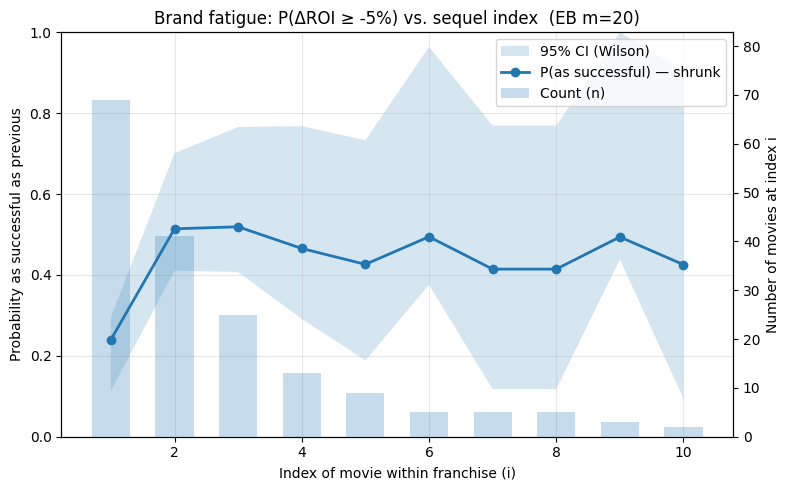

In [154]:
import matplotlib.pyplot as plt

# --- pull arrays ---
x  = result[index_in_brand_col].to_numpy()
y  = result['p_shrunk'].to_numpy()
lo = result['wilson_lo'].to_numpy()
hi = result['wilson_hi'].to_numpy()
n  = result['n'].to_numpy()

# --- plot ---
fig, ax1 = plt.subplots(figsize=(8, 5))

# CI ribbon + shrunk estimate
ax1.fill_between(x, lo, hi, alpha=0.18, label='95% CI (Wilson)')
ax1.plot(x, y, marker='o', linewidth=2, label='P(as successful) — shrunk')

ax1.set_xlabel('Index of movie within franchise (i)')
ax1.set_ylabel('Probability as successful as previous')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Secondary axis: sample size per index (sparsity)
ax2 = ax1.twinx()
ax2.bar(x, n, width=0.6, alpha=0.25, edgecolor='none', label='Count (n)')
ax2.set_ylabel('Number of movies at index i')
ax2.set_ylim(0, max(n)*1.2 if len(n) else 1)

# One legend for both axes
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper right')

# Title with your tolerance and shrinkage 'm'
tol_str = f"{tol:+.0%}" if abs(tol) >= 0.005 else f"{tol:.3f}"
ax1.set_title(f'Brand fatigue: P(ΔROI ≥ {tol_str}) vs. sequel index  (EB m={m})')

plt.tight_layout()
plt.show()
